## 1. 라이브러리 및 데이터
## Library & Data

In [1]:
#Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from easydict import EasyDict
from datetime import timedelta
import warnings
import copy
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,cross_val_score
from sklearn.model_selection import KFold
from xgboost.sklearn import XGBRegressor
import GPy
import GPyOpt
from GPyOpt.methods import BayesianOptimization
warnings.filterwarnings(action='ignore') 

In [2]:
# Data loading
target = pd.read_csv('target_v2.csv')
weather = pd.read_csv('weather_v2.csv')
smp = pd.read_csv('hourly_smp_v2.csv')

## 2. 데이터 전처리
## Data Cleansing & Pre-Processing  

### 모델 구축 시 사용할 지점 및 기상 속성 선정 과정
- 사용지점 (4곳): ASOS 지점 (고산, 성산, 제주, 서귀포)
  - (ASOS : 종관기상관측장비 <-> AWS : 방재기상관측장비)


- 선정 이유
    1. 사람이 항상 상주하며, 온도를 왜곡시킬 수 있는 요소를 모두 배제한 위치를 선정
    (출처 :https://www.yna.co.kr/view/AKR20180723154300004)
    2. ASOS 지점 데이터는 공식적인 지표로 활용됨.
    
    
- 사용 기상 속성
    1. 일 평균기온
    2. 일 최고기온
    3. 일 최저기온
    
    
- 선정 이유
    1. Supply 와 해당 기온 속성들의 상관계수가 높음
    2. 계절적 특성이 강하게 나타남
    3. 선행 연구에서 SMP 예측 시, 기상요소 중 기온을 가장 중요한 지표로 활용 
    (KPX 연구보고서, "제주도 단기전력수요예측 알고리즘 개발", 2019)


In [3]:
start = '2018-02-01'
end = '2020-05-18'

# target_v2.csv
# date 년,월,일,주,일 단위 분리
target['date'] = pd.to_datetime(target['date'])
target['year'] = target['date'].dt.year
target['month'] = target['date'].dt.month
target['day'] = target['date'].dt.day
target['week'] = target['date'].dt.week
target['dayofweek'] = target['date'].dt.dayofweek
target['weekofyear'] = target['date'].dt.weekofyear

# weather_v2.csv
weather = weather[weather['station'] == 'ASOS']
weather['datetime'] = pd.to_datetime(weather['datetime'])
weather = weather.loc[:,'area':'temp']

# weather 중 ASOS area 선별
weather_list = []
for area in weather['area'].unique():
    weather_list.append(weather[weather['area']==area].copy())
    
for i, area in enumerate(weather['area'].unique()):
    weather_list[i].drop(['area'], axis=1, inplace=True)
    weather_list[i].columns = ['datetime', str(area)+'_temp']
    
hourly_temperature = pd.DataFrame()
hourly_temperature['datetime'] = pd.date_range(start, end, freq='H',closed='right')

for day in weather_list:
    hourly_temperature  = hourly_temperature.merge(day, how='outer')

# ASOS area 데이터 통합    
hourly_temperature.set_index('datetime',inplace=True)
hourly_temp_max = hourly_temperature.resample('D').max().mean(axis=1)
hourly_temp_mean = hourly_temperature.resample('D').mean().mean(axis=1)
hourly_temp_min = hourly_temperature.resample('D').min().mean(axis=1)

# smp
smp['datetime'] = smp.datetime.apply(
    lambda x:dt.datetime(
        year=int(x[:4]),
        month=int(x[5:7]),
        day=int(x[8:10]),
        hour=int(x[11:13])-1,
        minute=int(x[14:16])
    ))

### data melting

In [4]:
train_merge = pd.concat([target,
                         pd.DataFrame(
    data=pd.concat([hourly_temp_max, hourly_temp_mean,
                    hourly_temp_min],axis=1).values,
    columns=['temp_max','temp_mean','temp_min'])],axis=1)

In [5]:
train_merge.to_csv('smp_train.csv')

## 3. 탐색적 자료분석
## Exploratory Data Analysis


<AxesSubplot:xlabel='date'>

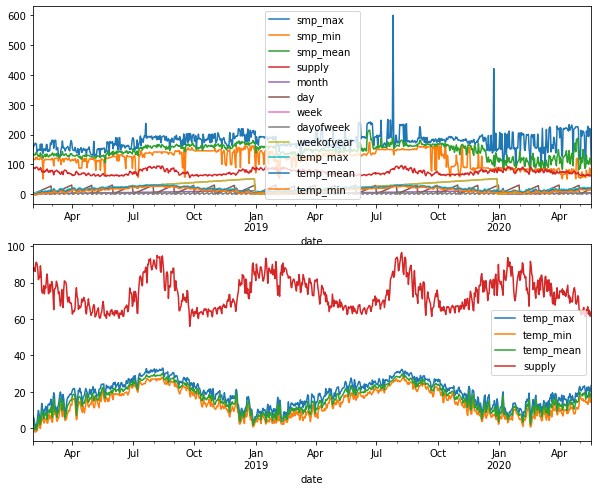

In [6]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(211)

train_merge[
    [itm for itm in train_merge.columns if itm != 'year']].set_index('date').plot(ax=ax)
ax = fig.add_subplot(212)

train_merge[['date','temp_max','temp_min','temp_mean','supply']].set_index('date').plot(ax=ax)

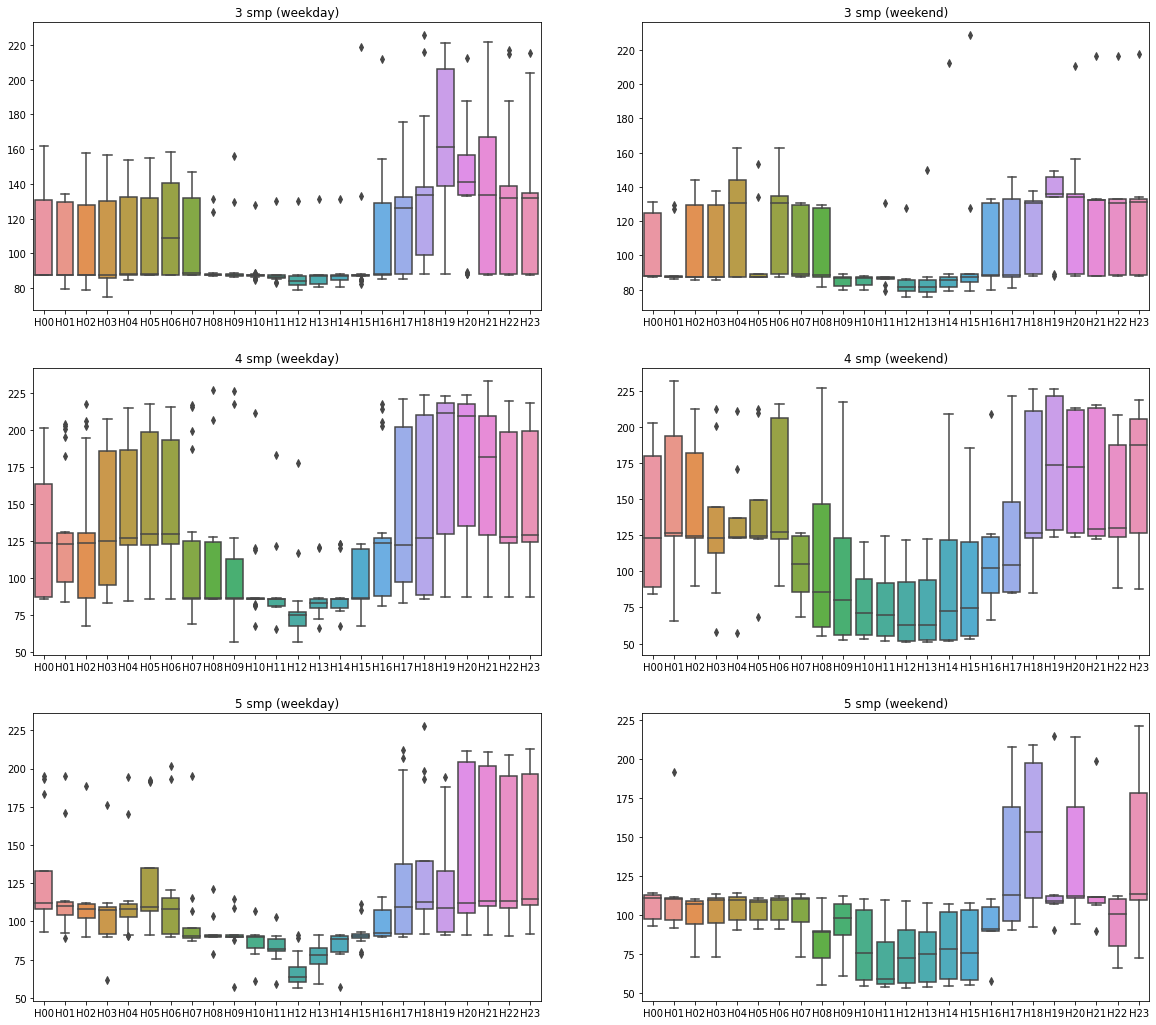

In [7]:
sample_smp = copy.copy(smp.loc[smp.datetime>='2019-12-01'])
sample_smp.datetime = pd.to_datetime(sample_smp.datetime)
fig = plt.figure(figsize=(10*2,6*3))
for idx, itm in enumerate([3,4,5]):
    ax = fig.add_subplot(3,2,2*idx+1)
    ax.set_title('%d smp (weekday)'%itm)
    sample = sample_smp.loc[(sample_smp.datetime.dt.month==itm)&
                            (sample_smp.datetime.dt.dayofweek<5)]
    sample = pd.DataFrame(sample.smp.values.reshape([-1,24]), 
                  columns=['H'+('%d'%i).zfill(2) for i in range(24)])
    sns.boxplot(ax=ax, data=sample)
    
for idx, itm in enumerate([3,4,5]):
    ax = fig.add_subplot(3,2,2*idx+2)
    ax.set_title('%d smp (weekend)'%itm)
    sample = sample_smp.loc[(sample_smp.datetime.dt.month==itm)&
                            (sample_smp.datetime.dt.dayofweek>=5)]
    sample = pd.DataFrame(sample.smp.values.reshape([-1,24]), 
                  columns=['H'+('%d'%i).zfill(2) for i in range(24)])
    sns.boxplot(ax=ax, data=sample)

In [8]:
# 각 온도 시나리오 시계열 데이터 특성 분석 모듈
def plot_decompose(decomposeresult):
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4,1, figsize=(15,8))
    plt.subplots_adjust(hspace = 0.5)
    decomposeresult.observed.plot(legend=False, color='black', ax=ax1)
    ax1.set_ylabel('Observerd')
    decomposeresult.trend.plot(legend=False, color='black', ax=ax2)
    ax2.set_ylabel('Trend')
    decomposeresult.seasonal.plot(legend=False, color='black', ax=ax3)
    ax3.set_ylabel('Seasonal')
    decomposeresult.resid.plot(legend=False,color='black', ax=ax4)
    ax4.set_ylabel('Resid')
    
def check_acf_pacf(temp_data,diff):
    df = pd.DataFrame(columns=['station'])
    # Stationary data
    data =temp_data[(temp_data.index.year ==2018)&
                       (temp_data.index.month.isin([2,3,4,5,6,7,8]))]
    if diff != 0:
        df['station'] = data - data.rolling(diff).mean()
    else:
        df['station'] = data

    fig, ax = plt.subplots(3, figsize=(12,6))
    x = df['station']
    ax[0] = plot_acf(x, ax=ax[0], lags=50)
    ax[1] = plot_pacf(x, ax=ax[1], lags=50)
    ax[2].plot(x)

### TemP_MAX 시나리오 예시

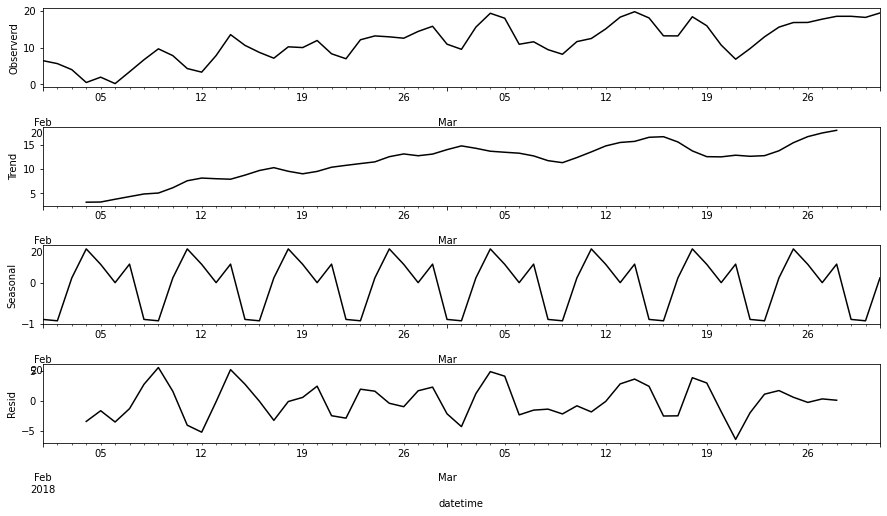

In [9]:
# !Pip install statsmodels
result = seasonal_decompose(hourly_temp_max[(hourly_temp_max.index.year ==2018) &
                                           (hourly_temp_max.index.month.isin([2,3]))], 
                            model='additive'
                           )
plot_decompose(result)

### ACF, PACF 그래프를 이용해 S-ARIMA 모델의 모수 결정
- ACF(Auto Correlation Function), PACF(Patial Auto Correlation Function)
- ARIMA 모수는 (p,d,q), (P,D,Q,freq) 로 결정됨

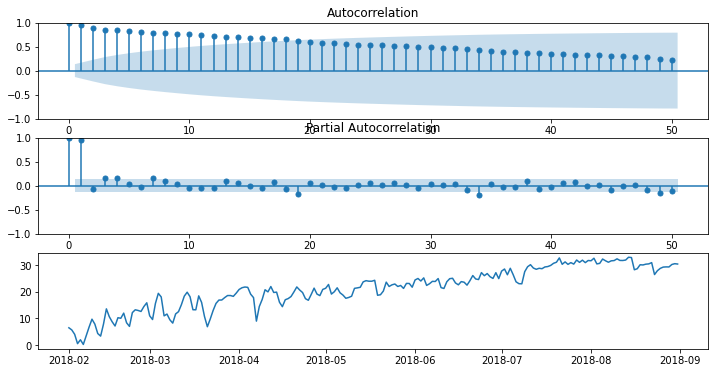

In [10]:
# 다음 그래프를 통해 최대 기온 S-ARIMA 모델 모수 결정
# param = (p,d,q) = (0,0,0), 
# sparam = (P,D,Q,freq) = (1,0,3,7)
check_acf_pacf(hourly_temp_max,0)

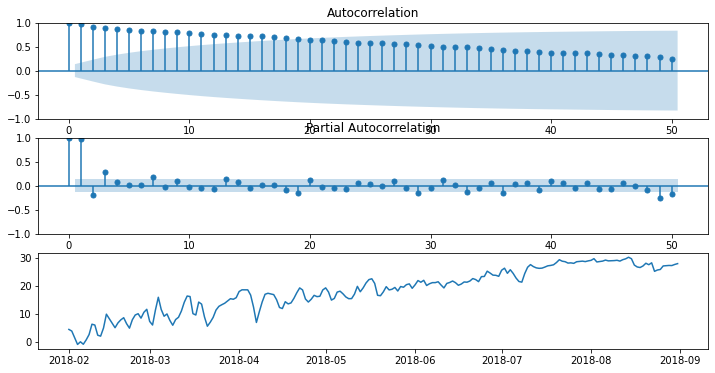

In [11]:
# 다음 그래프를 통해 평균 기온 S-ARIMA 모델 모수 결정
# param = (p,d,q) = (0,0,2), 
# sparam = (P,D,Q,freq) = (3,0,3,7)
check_acf_pacf(hourly_temp_mean,0)

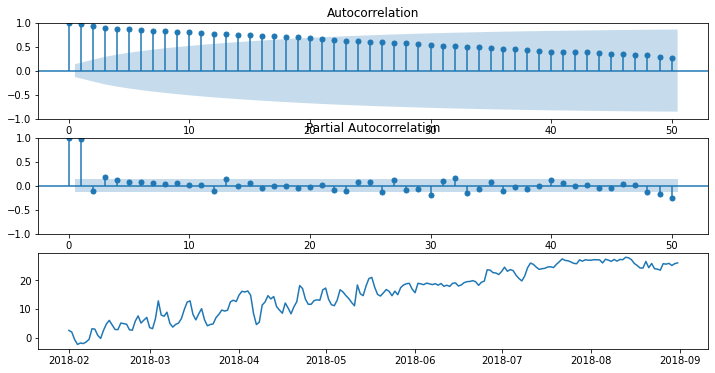

In [12]:
# 다음 그래프를 통해 최소 기온 S-ARIMA 모델 모수 결정
# param = (p,d,q) = (0,0,0), 
# sparam = (P,D,Q,freq) = (4,0,4,7)
check_acf_pacf(hourly_temp_min,0)

## 4. 변수 선택 및 모델 구축
## Feature Engineering & Initial Modeling  

In [13]:
# 주어진 모델 파라미터에 따라 S-ARIMA 모델 생성
def make_arima_model(data,end_day,param,sparam):
    end_day = pd.to_datetime(end_day)
    data = data[data.index < end_day]

    mod = sm.tsa.statespace.SARIMAX(data,
                                    order=param,
                                    seasonal_order=sparam,
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

    results = mod.fit()
    return results

# 실측값과 예측값을 비교하는 그래프 생성 함수
def show_result_plot(pred,y):
    plt.rcParams['figure.figsize'] = [6, 4]
    plt.plot(np.array(y), '.-', label='y_val')
    plt.plot(np.array(pred), '.-', label='y_pred')
    plt.legend()
    plt.show()
    print('============================')
    abs_result_min = abs(pred-y) 
    print('MAE:{}'.format(abs_result_min.mean()))
    print('============================')
    

# S-ARIMA 모델 생성
def get_arima_model(temp, tgtdate, tgtrange, param, sparam):
    # 테스트 기간 데이터 불러오기
    model = make_arima_model(temp,tgtdate,param,sparam)

    # 평가
    result = model.predict(start=tgtrange[0],end=tgtrange[1])
    y= temp[(temp.index >= tgtrange[0])
                     & (temp.index <= tgtrange[1])]
    return model, result, y

### 2020년 5월 25일 ~ 2020년 6월 21일 

- 최대 온도 시나리오 생성 모델 학습 및 예측성능 검증
- Validation 방법 : 전년 동기간 비교(2019년)
- Validation 대상 : 최고기온, 평균기온, 최소기온

### 4-1. S-ARIMA를 이용한 최고기온 예측모델 평가 (max_model)

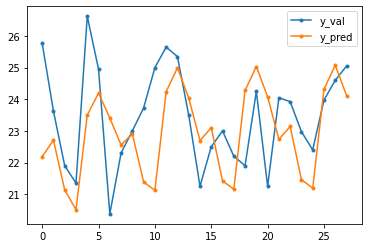

MAE:1.398085485989185


In [14]:
# ACF/PACF 분석 결과 활용
param = (0,0,0)
sparam = (1,0,3,7)
_, result_temp_max, max_y = get_arima_model(temp=hourly_temp_max, 
                                         tgtdate='2019-05-20', 
                                         tgtrange=('2019-05-25','2019-06-21'), 
                                         param=param, 
                                         sparam=sparam)
show_result_plot(result_temp_max,max_y)

### 4-2. S-ARIMA를 이용한 평균기온 예측모델 평가 (mean_model)

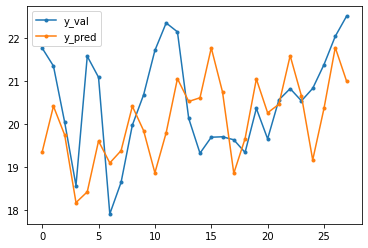

MAE:1.1076667201585846


In [15]:
# ACF/PACF 분석 결과 활용
param = (0,0,2)
sparam = (3,0,3,7)
_, result_temp_mean, mean_y = get_arima_model(temp=hourly_temp_mean, 
                                             tgtdate='2019-05-20', 
                                             tgtrange=('2019-05-25','2019-06-21'), 
                                             param=param, 
                                             sparam=sparam)
show_result_plot(result_temp_mean,mean_y)

### 4-3. S-ARIMA를 이용한 최소기온 예측모델 평가 (max_model)

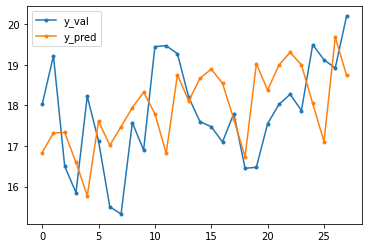

MAE:1.2332388412164905


In [16]:
# ACF/PACF 분석 결과 활용
param = (0,0,0)
sparam = (4,0,4,7)
_, result_temp_min, min_y = get_arima_model(temp=hourly_temp_min, 
                                             tgtdate='2019-05-20', 
                                             tgtrange=('2019-05-25','2019-06-21'), 
                                             param=param, 
                                             sparam=sparam)
show_result_plot(result_temp_min,min_y)

### 4-4. 2019년 예측일자 온도 시나리오 생성

In [17]:
# 생성된 시나리오 storage
sc = pd.DataFrame()
# 최대 온도 시나리오
sc['maxtemp19'] = result_temp_max

# 평균 온도 시나리오
sc['avgtemp19'] = result_temp_mean

# 최소 온도 시나리오
sc['mintemp19'] = result_temp_min

### 4-5. 2020년 예측일자 온도 시나리오 생성

In [18]:
# 최대 온도 시나리오
param = (0,0,0)
sparam = (1,0,3,7)
max_model = make_arima_model(hourly_temp_max,'2020-05-20',param,sparam)
sc['maxtemp20'] = max_model.predict(start='2020-05-25',end='2020-06-21')

# 평균 온도 시나리오
param = (0,0,2)
sparam = (3,0,3,7)
mean_model = make_arima_model(hourly_temp_mean,'2020-05-20',param,sparam)
sc['avgtemp20'] = mean_model.predict(start='2020-05-25',end='2020-06-21')

# 최소 온도 시나리오
param = (0,0,0)
sparam = (4,0,4,7)
min_model = make_arima_model(hourly_temp_min,'2020-05-20',param,sparam)
sc['mintemp20'] = min_model.predict(start='2020-05-25',end='2020-06-21')

## 5. 모델 학습 및 검증
## Model Tuning & Evaluation

### 5-1. Supply 생성 모델 (2020년 수요 시나리오 생성)

- xgboost 모델 적용

In [19]:
def split_train_test_set(df, tgtdate,
                         hourly_temp_max, hourly_temp_mean, hourly_temp_min):
    # daily 수요예측을 위해 필요한 데이터 전처리
    target = df.set_index('date')

    # 데이터 셋 갈무리
    train_supply = target[target.index < pd.to_datetime(tgtdate)]['supply']
    train_max = hourly_temp_max[hourly_temp_max.index < pd.to_datetime(tgtdate)]
    train_mean = hourly_temp_mean[hourly_temp_mean.index < pd.to_datetime(tgtdate)]
    train_min = hourly_temp_min[hourly_temp_min.index < pd.to_datetime(tgtdate)]
    train_total= pd.concat([train_supply,train_max,train_mean,train_min],axis=1)

    # supply 예측 데이터 세팅
    monthData =pd.DataFrame(train_total.index.month,columns=['month'])
    dayofweekData=pd.DataFrame(train_total.index.dayofweek,columns=['dayofweek'])
    x_train = pd.concat([train_total[[0,1,2]].reset_index(drop=True),monthData
                        ,dayofweekData],axis=1)
    y_train = train_total.supply

    # 테스트 데이터 셋
    testtemp = pd.concat([result_temp_max,result_temp_mean,result_temp_min],axis=1)
    testmonth = pd.DataFrame(testtemp.index.month.values,columns=['month'])
    testdayofweek = pd.DataFrame(testtemp.index.dayofweek.values,columns=['dayofweek'])
    total_test = pd.concat([testtemp.reset_index(drop=True),testmonth,testdayofweek],axis=1)
    return x_train, y_train, total_test

- xgboost 모델 학습(베이지안 최적화이용)

In [20]:
# 최적화 탐색 boundary 정리
bds = [{'name': 'learning_rate', 'type': 'continuous', 'domain': (0, 1)},
        {'name': 'gamma', 'type': 'continuous', 'domain': (0, .5)},
        {'name': 'max_depth', 'type': 'discrete', 'domain': (1, 5)},
        {'name': 'n_estimators', 'type': 'discrete', 'domain': (100, 300)},
        {'name': 'min_child_weight', 'type': 'discrete', 'domain': (1, 10)}]

Bayesian optimization neg. MAE = -2.47


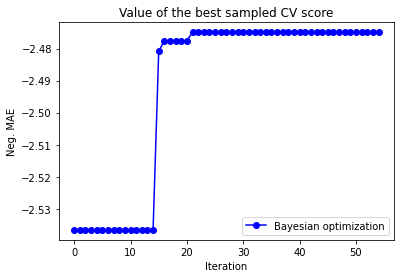

In [21]:
# Bayesian Optimization objective 
x_train, y_train, total_test = split_train_test_set(
    target, '2020-05-20', hourly_temp_max,hourly_temp_mean, hourly_temp_min)

def cv_score(parameters):
    parameters = parameters[0]
    score = cross_val_score(
                XGBRegressor(learning_rate=parameters[0],
                              gamma=int(parameters[1]),
                              max_depth=int(parameters[2]),
                              n_estimators=int(parameters[3]),
                              min_child_weight = parameters[4]), 
                x_train, y_train, scoring='neg_mean_absolute_error').mean()
    score = np.array(score)
    return score

# 최적화 객체 생성
optimizer = BayesianOptimization(f=cv_score, 
                                 domain=bds,
                                 model_type='GP',
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.1,
                                 exact_feval=True, 
                                 maximize=True)

# 50번의 iteration 통해서 최적 파라미터 탐색
optimizer.run_optimization(max_iter=50)

y_bo = np.maximum.accumulate(-optimizer.Y).ravel()
print(f'Bayesian optimization neg. MAE = {y_bo[-1]:.2f}')
plt.plot(y_bo, 'bo-', label='Bayesian optimization')
plt.xlabel('Iteration')
plt.ylabel('Neg. MAE')
plt.title('Value of the best sampled CV score')
plt.legend()

- 최적 파라미터를 가진 모델 생성

In [34]:
from sklearn.model_selection import train_test_split
print(x_train, y_train)
# X_train, X_test, y_train, y_test = train_test_split(
# x_train, y_train, test_size = 0.2, random_state=42)

# best = optimizer.x_opt
# finalsupply = XGBRegressor(learning_rate=best[0],
#                               gamma=int(best[1]),
#                               max_depth=int(best[2]),
#                               n_estimators=int(best[3]),
#                               min_child_weight = best[4])
# finalsupply.fit(X_train,y_train)
# print("Accuracy on training set:{:.5f}".format(finalsupply.score(X_train, y_train)))
# print("Accuracy on test set:{:.5f}".format(finalsupply.score(X_test, y_test)))

          0          1       2  month  dayofweek
0     6.475   4.346739   2.550      2          3
1     5.675   3.760417   1.975      2          4
2     4.025   1.337500  -0.625      2          5
3     0.525  -1.017708  -2.300      2          6
4     1.975  -0.077083  -1.800      2          0
..      ...        ...     ...    ...        ...
468  25.325  20.987500  17.000      5          2
469  25.600  21.804167  18.075      5          3
470  24.150  20.728125  17.575      5          4
471  21.625  19.909375  18.125      5          5
472  22.775  20.241667  17.550      5          6

[473 rows x 5 columns] 2018-12-05    73.29
2018-02-23    80.26
2019-03-02    77.48
2018-03-19    76.30
2018-10-08    63.30
              ...  
2018-05-18    66.97
2018-10-29    64.80
2019-01-15    87.05
2019-04-12    77.04
2018-05-14    63.13
Name: supply, Length: 378, dtype: float64


    predicted_mean  predicted_mean  predicted_mean  month  dayofweek
0        22.185704       19.354413       16.838415      5          5
1        22.706756       20.420142       17.322145      5          6
2        21.134146       19.747861       17.332934      5          0
3        20.508624       18.175385       16.594449      5          1
4        23.498684       18.424972       15.777090      5          2
5        24.197862       19.609435       17.608711      5          3
6        23.406945       19.098287       17.019005      5          4
7        22.556215       19.384793       17.476558      6          5
8        22.903815       20.417803       17.947583      6          6
9        21.385739       19.848982       18.324024      6          0
10       21.121143       18.867793       17.796678      6          1
11       24.239863       19.801406       16.820654      6          2
12       24.993487       21.061178       18.757516      6          3
13       24.038437       20.529986

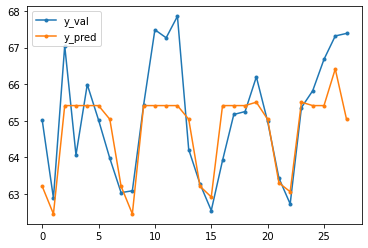

MAE:nan


In [23]:
## 예측 수행
sc['supply20'] = finalsupply.predict(total_test)
print(total_test)
## 과거 동일 기간 패턴과 비교하여 검증 수행
supply_past = target.loc[(target.date > dt.datetime(2019,5,24)) &
       (target.date < dt.datetime(2019,6,22))]['supply']
show_result_plot(sc['supply20'],supply_past)

### 5-2. 2019년 수요 시나리오 생성(xgb)

In [24]:
# bayesian optimaztion을 위해서는 x_train, y_train이 글로벌변수로 선언되어야함
x_train, y_train, total_test = split_train_test_set(
    target, '2019-05-20', hourly_temp_max,hourly_temp_mean, hourly_temp_min)
# print(target
#       , '2019-05-20'
#       , hourly_temp_max
#       , hourly_temp_mean
#       , hourly_temp_min
#      )
print(
    x_train
    , y_train
    , total_test
     )

          0          1       2  month  dayofweek
0     6.475   4.346739   2.550      2          3
1     5.675   3.760417   1.975      2          4
2     4.025   1.337500  -0.625      2          5
3     0.525  -1.017708  -2.300      2          6
4     1.975  -0.077083  -1.800      2          0
..      ...        ...     ...    ...        ...
468  25.325  20.987500  17.000      5          2
469  25.600  21.804167  18.075      5          3
470  24.150  20.728125  17.575      5          4
471  21.625  19.909375  18.125      5          5
472  22.775  20.241667  17.550      5          6

[473 rows x 5 columns] 2018-02-01    87.47
2018-02-02    86.64
2018-02-03    88.28
2018-02-04    86.14
2018-02-05    90.63
              ...  
2019-05-15    67.16
2019-05-16    67.45
2019-05-17    65.81
2019-05-18    62.51
2019-05-19    62.95
Name: supply, Length: 473, dtype: float64     predicted_mean  predicted_mean  predicted_mean  month  dayofweek
0        22.185704       19.354413       16.838415      5

Bayesian optimization neg. MAE = -3.10


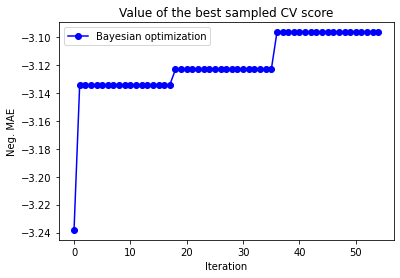

In [25]:
# 최적화 객체 생성
optimizer = BayesianOptimization(f=cv_score, 
                                 domain=bds,
                                 model_type='GP',
                                 acquisition_type ='EI',
                                 acquisition_jitter = 0.1,
                                 exact_feval=True, 
                                 maximize=True)

# 50번의 iteration 통해서 최적 파라미터 탐색
optimizer.run_optimization(max_iter=50)

y_bo = np.maximum.accumulate(-optimizer.Y).ravel()
print(f'Bayesian optimization neg. MAE = {y_bo[-1]:.2f}')
plt.plot(y_bo, 'bo-', label='Bayesian optimization')
plt.xlabel('Iteration')
plt.ylabel('Neg. MAE')
# plt.ylim(-5000, -3000)
plt.title('Value of the best sampled CV score');
plt.legend();

In [26]:
import joblib
best = optimizer.x_opt
finalsupply = XGBRegressor(learning_rate=best[0],
                              gamma=int(best[1]),
                              max_depth=int(best[2]),
                              n_estimators=int(best[3]),
                              min_child_weight = best[4])
finalsupply.fit(x_train,y_train)
print(x_train)
joblib.dump(finalsupply, 'smp_data/supply_model.pkl')

          0          1       2  month  dayofweek
0     6.475   4.346739   2.550      2          3
1     5.675   3.760417   1.975      2          4
2     4.025   1.337500  -0.625      2          5
3     0.525  -1.017708  -2.300      2          6
4     1.975  -0.077083  -1.800      2          0
..      ...        ...     ...    ...        ...
468  25.325  20.987500  17.000      5          2
469  25.600  21.804167  18.075      5          3
470  24.150  20.728125  17.575      5          4
471  21.625  19.909375  18.125      5          5
472  22.775  20.241667  17.550      5          6

[473 rows x 5 columns]


['smp_data/supply_model.pkl']

    predicted_mean  predicted_mean  predicted_mean  month  dayofweek
0        22.185704       19.354413       16.838415      5          5
1        22.706756       20.420142       17.322145      5          6
2        21.134146       19.747861       17.332934      5          0
3        20.508624       18.175385       16.594449      5          1
4        23.498684       18.424972       15.777090      5          2
5        24.197862       19.609435       17.608711      5          3
6        23.406945       19.098287       17.019005      5          4
7        22.556215       19.384793       17.476558      6          5
8        22.903815       20.417803       17.947583      6          6
9        21.385739       19.848982       18.324024      6          0
10       21.121143       18.867793       17.796678      6          1
11       24.239863       19.801406       16.820654      6          2
12       24.993487       21.061178       18.757516      6          3
13       24.038437       20.529986

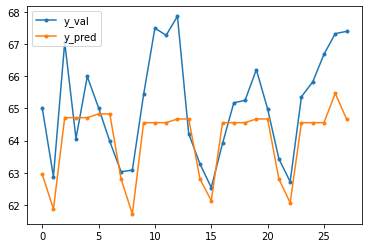

MAE:nan


In [27]:
## 예측 수행
sc['supply19'] = finalsupply.predict(total_test)
print(total_test)

## 과거 동일 기간 패턴과 비교하여 검증 수행
supply_past = target.loc[(target.date > dt.datetime(2019,5,24)) &
       (target.date < dt.datetime(2019,6,22))]['supply']
show_result_plot(sc['supply19'],supply_past)

### 5-3. SMP 예측 모델

- 기상시나리오, 수요시나리오 사용

In [28]:
# 시나리오 데이터 확인
for itm in sc:
    print(itm)
sc.to_csv('smp_data/smp_sc')

maxtemp19
avgtemp19
mintemp19
maxtemp20
avgtemp20
mintemp20
supply20
supply19


In [29]:
import joblib
def getRefDate(tgtyear, tgtWOY, tgtDOW):
    ref = pd.DataFrame()
    ref['tDateTime'] = pd.date_range(start='{}-01-01'.format(tgtyear),
                        end='{}-12-31'.format(tgtyear), 
                        freq='D')
    return ref.loc[(ref.tDateTime.dt.weekofyear==tgtWOY)
                   &(ref.tDateTime.dt.dayofweek==tgtDOW)].tDateTime.dt.date.values[0]

def getRefDateTimeRange(refyear, srtdate, enddate):
    """
    refyear = 2018
    srtdate = (string) start date ex) '2020-02'
    enddate = (string) end date 
    """
    df = pd.DataFrame()
    df['tDateTime'] = pd.date_range(start=srtdate, end=enddate, freq='D')
    
    refsrtdate = getRefDate(refyear, 
                            df.tDateTime.dt.weekofyear.values[0], 
                            df.tDateTime.dt.dayofweek.values[0])
    
    refenddate = getRefDate(refyear, 
                            df.tDateTime.dt.weekofyear.values[-1], 
                            df.tDateTime.dt.dayofweek.values[-1])

    ref = pd.date_range(start=refsrtdate, 
                        end=refenddate,
                        freq='D')
    
    return ref

def getDataSet(tdf, sc, tgtvariable, srcrange, tgtrange):
    trainx = tdf.loc[(tdf.date>=srcrange[0])&
                     (tdf.date<=srcrange[1]),
                     ['temp_max','temp_min','temp_mean','dayofweek','weekofyear','supply']]
    trainy = tdf.loc[(tdf.date>=srcrange[0])&
                     (tdf.date<=srcrange[1]),[tgtvariable]]
    
    tmp = pd.date_range(start=tgtrange[0], end=tgtrange[1], freq='D')
    testx = pd.DataFrame()
    testx['temp_max'] = sc['maxtemp20'].values
    testx['temp_min'] = sc['mintemp20'].values
    testx['temp_mean'] = sc['avgtemp20'].values
    testx['supply'] = sc['supply20']
    testx['dayofweek'] = tmp.dayofweek
    testx['weekofyear'] = tmp.weekofyear
    testx= testx[['temp_max','temp_min','temp_mean','dayofweek','weekofyear','supply']]
    
    return trainx, trainy, testx

def getModel(trainx, trainy):
    model = XGBRegressor(
                max_depth=5,
                n_estimators=1000,
                learning_rate=0.05,
                booster='gbtree',
                tree_method='auto',  # "auto", "gpu_hist", "exact", "hist"
                n_jobs=1,
                gamma=0,
                min_child_weight=1.5,
                max_delta_step=0,
                subsample=0.6,  # 0.6,
                colsample_bytree=0.4,  # 0.4
                colsample_bylevel=1,
                colsample_bynode=1,
                reg_alpha=0.75,
                reg_lambda=0.45,
                scale_pos_weight=1,  # 1,
                base_score=.5,
                random_state=0,
                seed=7
            )

    model.fit(trainx, trainy)
    return model


def getResult(tdf, sc, tgtvariable, srcrange, tgtrange):
    trainx, trainy, testx = getDataSet(tdf, sc, tgtvariable, srcrange, tgtrange)
    #print(trainx, trainy)
    testx.to_csv("smp_data/smp_testx.csv")
    model = getModel(trainx, trainy)
    joblib.dump(model, 'smp_data/smp_model.pkl')
    print(testx)
    pred = model.predict(testx)
    
    return pred

In [30]:
trainx = train_merge.loc[
    (train_merge.date>'2020-04-01')][['temp_max','temp_min','temp_mean','dayofweek','weekofyear','supply']]
trainx.head(2)

,temp_max,temp_min,temp_mean,dayofweek,weekofyear,supply
791,14.925,9.525,11.875000,3,14,75.42
792,15.825,10.600,12.838542,4,14,75.03


## 6. 결과

In [31]:
smpavg = getResult(train_merge, sc, 'smp_mean',('2018-02-01','2022-05-18'),('2025-05-25', '2025-06-21'))

    temp_max  temp_min  temp_mean  dayofweek  weekofyear  supply
0        NaN       NaN        NaN          6          21     NaN
1        NaN       NaN        NaN          0          22     NaN
2        NaN       NaN        NaN          1          22     NaN
3        NaN       NaN        NaN          2          22     NaN
4        NaN       NaN        NaN          3          22     NaN
5        NaN       NaN        NaN          4          22     NaN
6        NaN       NaN        NaN          5          22     NaN
7        NaN       NaN        NaN          6          22     NaN
8        NaN       NaN        NaN          0          23     NaN
9        NaN       NaN        NaN          1          23     NaN
10       NaN       NaN        NaN          2          23     NaN
11       NaN       NaN        NaN          3          23     NaN
12       NaN       NaN        NaN          4          23     NaN
13       NaN       NaN        NaN          5          23     NaN
14       NaN       NaN   